In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import drawStyles
from scipy.cluster.hierarchy import leaders

df = pd.read_csv('/Users/samgeng14/PycharmProjects/LunaExchange/AAPL Price History.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

df = df.set_index('Date')
df = df.sort_index()

df = df[['Price', 'Open', 'High', 'Low', 'CVol']]

df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

df = df.dropna()
df = df.dropna()
print("Success! Here is the clean data:")
print(df.head())
%config Completer.use_jedi = False

Success! Here is the clean data:
            Price  Open  High   Low       CVol  Log_Return
Date                                                      
1993-02-02   0.54  0.54  0.55  0.54  182336170   -0.018349
1993-02-03   0.54  0.54  0.54  0.52  264185840    0.000000
1993-02-04   0.53  0.54  0.54  0.53  208152200   -0.018692
1993-02-05   0.51  0.53  0.53  0.50  367617940   -0.038466
1993-02-08   0.50  0.51  0.51  0.50  281075530   -0.019803


In [46]:
df['Momentum_5D'] = df['Price'].pct_change(5)

df['Volatility_5D'] = df['Log_Return'].rolling(window=5).std()

df['SMA_20'] = df['Price'].rolling(window=20).mean()
df['Price_to_SMA'] = df['Price'] / df['SMA_20']

df['Vol_Ratio'] = df['CVol'] / df['CVol'].rolling(window=5).mean()

df_features = df.dropna()
print("Features Engineered!")
print(df_features[['Price', 'Momentum_5D', 'Volatility_5D', 'Price_to_SMA', 'Vol_Ratio']].head())

Features Engineered!
            Price  Momentum_5D  Volatility_5D  Price_to_SMA  Vol_Ratio
Date                                                                  
1993-03-02   0.48     0.000000       0.025520      0.969697   0.726997
1993-03-03   0.49     0.020833       0.027135      0.994924   1.087659
1993-03-04   0.49     0.000000       0.025520      1.000000   0.988223
1993-03-05   0.49     0.042553       0.011414      1.004098   0.725127
1993-03-08   0.50     0.041667       0.011181      1.025641   1.069703


In [47]:
df['Range_3D'] = (df['High'] - df['Low']).rolling(window=3).mean()

df_features = df.dropna()

print("Final Feature Set Shape:", df_features.shape)
print(df_features[['Price', 'Momentum_5D', 'Volatility_5D', 'Range_3D']].head())

Final Feature Set Shape: (8252, 12)
            Price  Momentum_5D  Volatility_5D  Range_3D
Date                                                   
1993-03-02   0.48     0.000000       0.025520  0.013333
1993-03-03   0.49     0.020833       0.027135  0.013333
1993-03-04   0.49     0.000000       0.025520  0.013333
1993-03-05   0.49     0.042553       0.011414  0.010000
1993-03-08   0.50     0.041667       0.011181  0.013333


In [48]:
df_features['Next_Day_Return'] = df_features['Log_Return'].shift(-1)
print(df_features[['Log_Return', 'Next_Day_Return']].tail())

            Log_Return  Next_Day_Return
Date                                   
2025-12-03   -0.007154        -0.012216
2025-12-04   -0.012216        -0.006864
2025-12-05   -0.006864        -0.003198
2025-12-08   -0.003198        -0.002558
2025-12-09   -0.002558              NaN


In [49]:
#Convert These into Binary

df_features['Target'] = (df_features['Next_Day_Return'] > 0).astype(int)
df_model = df_features.dropna()
print("Good Target")

Good Target


In [50]:
counts = df_model['Target'].value_counts()
percent = df_model['Target'].value_counts(normalize=True) * 100

print(f"Total Up Days (1): {counts[1]} ({percent[1]:.2f}%)")
print(f"Total Down Days (0): {counts[0]} ({percent[0]:.2f}%)")

Total Up Days (1): 3621 (43.89%)
Total Down Days (0): 4630 (56.11%)


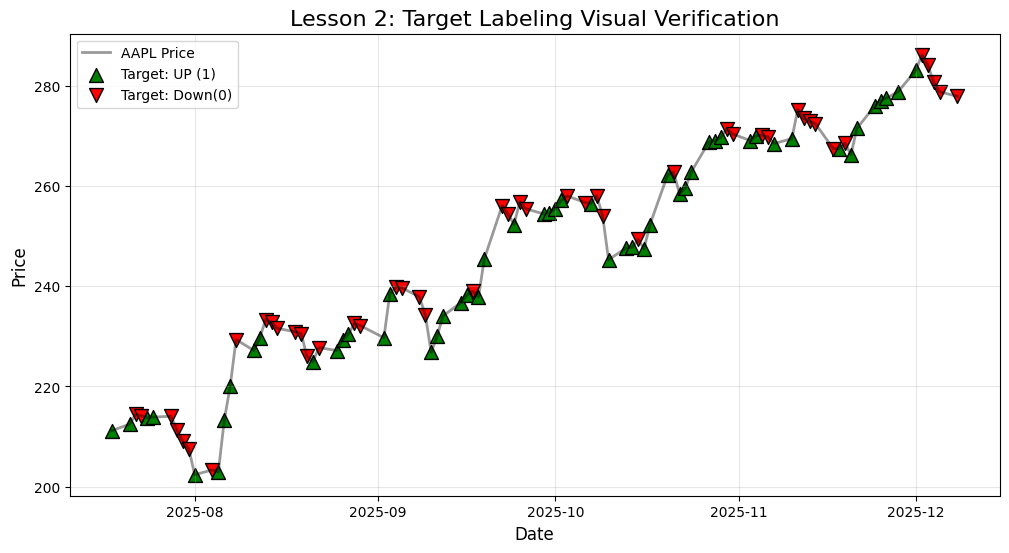

In [51]:
import matplotlib.pyplot as plt

plot_df = df_model.tail(100)

plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Price'], label='AAPL Price', color='black', alpha=0.4, lw=2)

up_signals = plot_df[plot_df['Target'] == 1]
plt.scatter(up_signals.index, up_signals['Price'],
            label='Target: UP (1)', marker= '^', color='green', s=100,
            edgecolors = 'black')

down_signals = plot_df[plot_df['Target'] == 0]
plt.scatter(down_signals.index, down_signals['Price'],
            label = 'Target: Down(0)', marker='v', color='red', s=100,
            edgecolors='black')
plt.title("Lesson 2: Target Labeling Visual Verification", fontsize = 16)
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Price", fontsize = 12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
split_index = int(len(df_model) *  0.8)

print(f"Total Rows: {len(df_model)}")
print(f"The 80% mark is at row: {split_index}")

Total Rows: 8251
The 80% mark is at row: 6600


In [53]:
#We use iloc to slice
train_df = df_model.iloc[:split_index]

test_df = df_model.iloc[split_index:]

print(f"Training days: {len(train_df)}")
print(f"Testing days: {len(test_df)}")

Training days: 6600
Testing days: 1651


In [54]:
feature_cols = ['Momentum_5D', "Volatility_5D", "Price_to_SMA", "Vol_Ratio", 'Range_3D']

X_train = train_df[feature_cols]
y_train = train_df['Target']

X_test = test_df[feature_cols]
y_test = test_df['Target']

print("Features and Targets Separated")

Features and Targets Separated


In [55]:
# Print the last date of training and the first date of testing
print(f"Last day of Training: {X_train.index[-1]}")
print(f"First day of Testing: {X_test.index[0]}")

# This logic check should return True
print("Is there a gap? ", X_test.index[0] > X_train.index[-1])

Last day of Training: 2019-05-15 00:00:00
First day of Testing: 2019-05-16 00:00:00
Is there a gap?  True


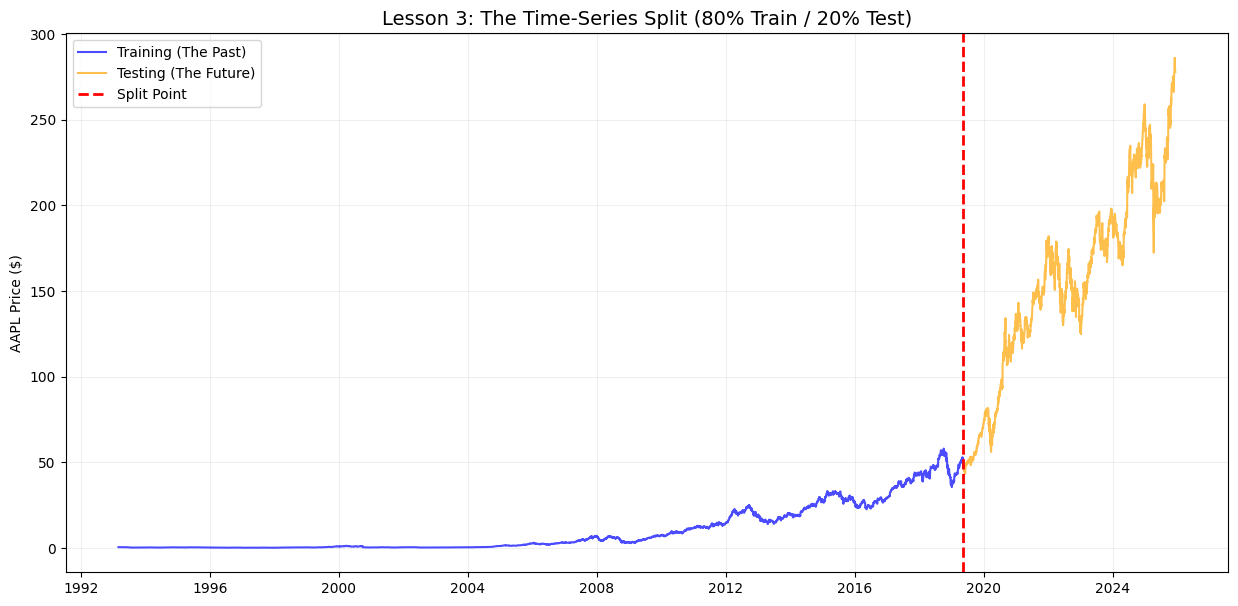

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot the Training price in Blue
plt.plot(train_df.index, train_df['Price'], label='Training (The Past)', color='blue', alpha=0.7)

# Plot the Testing price in Orange
plt.plot(test_df.index, test_df['Price'], label='Testing (The Future)', color='orange', alpha=0.7)

# Add a vertical dashed line to mark the "Today" split point
plt.axvline(train_df.index[-1], color='red', linestyle='--', lw=2, label='Split Point')

plt.title("Lesson 3: The Time-Series Split (80% Train / 20% Test)", fontsize=14)
plt.ylabel("AAPL Price ($)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [57]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
print("Complete")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test)[:, 1]

print("Done")

Done


In [ ]:
# Let's look at the weights (coefficients) the model assigned to each clue
importance = pd.DataFrame({'Feature': feature_cols, 'Weight': model.coef_[0]})
importance = importance.sort_values(by='Weight', ascending=False)

print("What the model learned:")
print(importance)

What the model learned:
         Feature    Weight
4       Range_3D  0.973580
2   Price_to_SMA  0.782044
3      Vol_Ratio  0.064070
0    Momentum_5D -0.877123
1  Volatility_5D -1.827342


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2%}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

Overall Accuracy: 53.24%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.00      0.01       771
           1       0.53      1.00      0.69       880

    accuracy                           0.53      1651
   macro avg       0.48      0.50      0.35      1651
weighted avg       0.48      0.53      0.37      1651



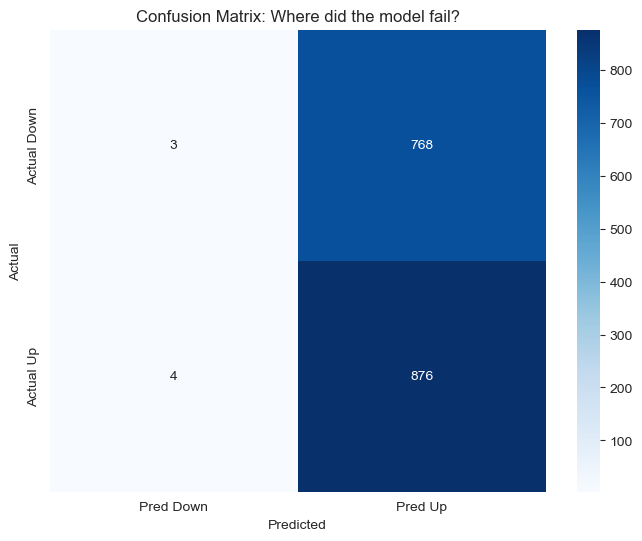

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Down', 'Pred Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: Where did the model fail?')
plt.show()

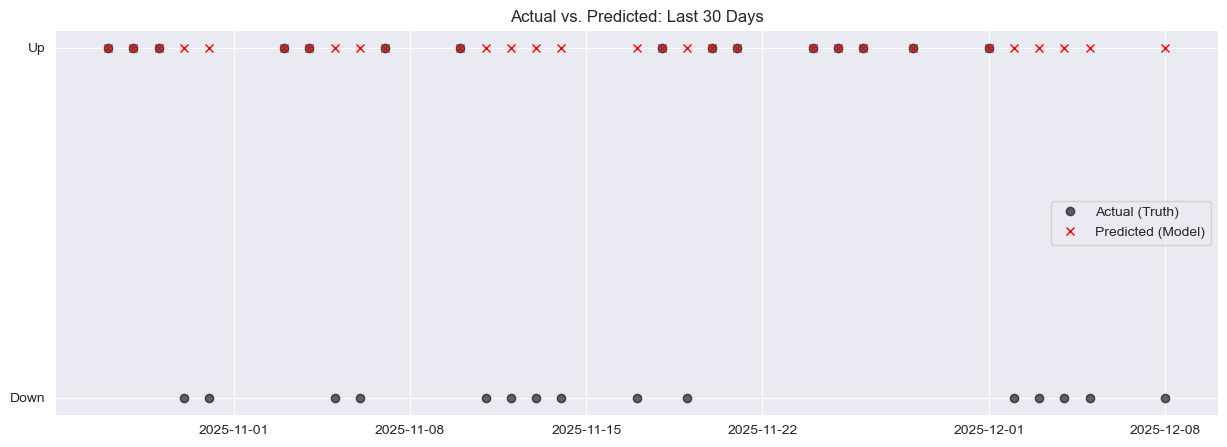

In [ ]:
# Create a DataFrame to compare them side-by-side
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Let's look at the last 30 trading days
comparison_slice = comparison.tail(30)

plt.figure(figsize=(15, 5))
plt.plot(comparison_slice.index, comparison_slice['Actual'], label='Actual (Truth)', marker='o', linestyle='', alpha=0.6, color='black')
plt.plot(comparison_slice.index, comparison_slice['Predicted'], label='Predicted (Model)', marker='x', linestyle='', color='red')

plt.title("Actual vs. Predicted: Last 30 Days")
plt.yticks([0, 1], ['Down', 'Up'])
plt.legend()
plt.show()

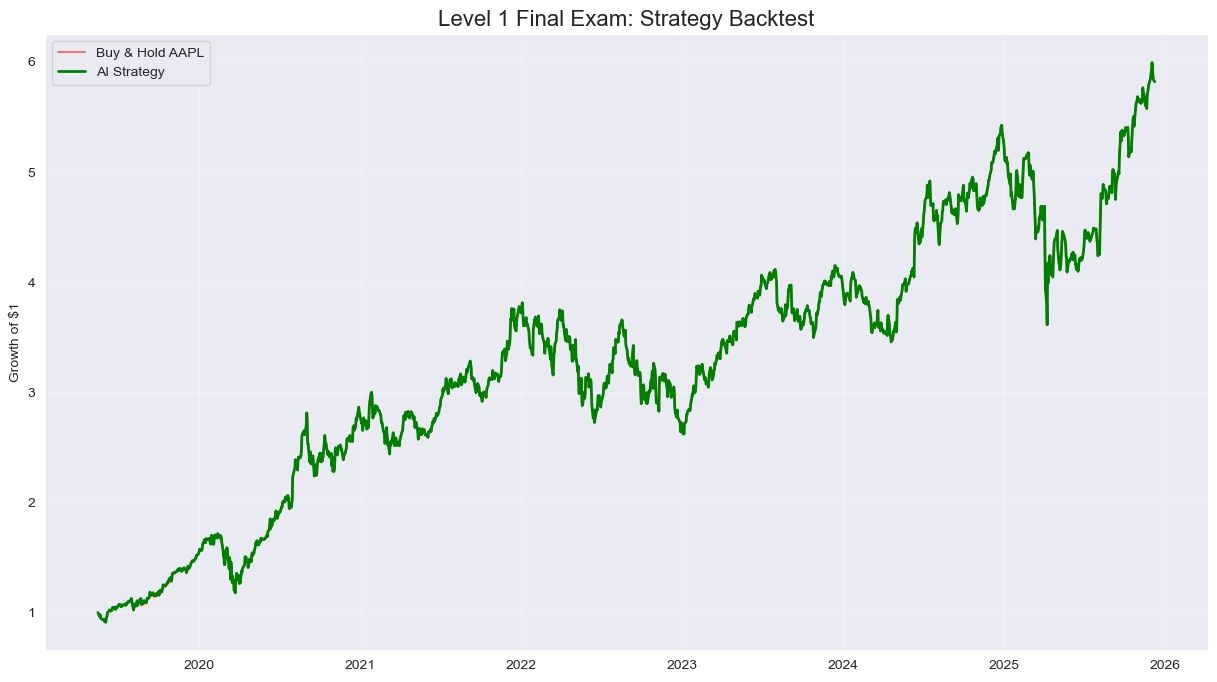

In [ ]:
#Backtester

backtest_df = test_df.copy()

backtest_df['Model_Signal'] = y_pred

backtest_df['Strategy_Return'] = backtest_df['Model_Signal'] * backtest_df['Log_Return']

backtest_df['Market_Growth'] = np.exp(backtest_df['Log_Return'].cumsum())
backtest_df['Strategy_Growth'] = np.exp(backtest_df['Strategy_Return'].cumsum())

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(backtest_df.index, backtest_df['Market_Growth'], label='Buy & Hold AAPL', color='red', alpha=0.5)
plt.plot(backtest_df.index, backtest_df['Strategy_Growth'], label='AI Strategy', color='green', lw=2)

plt.title("Level 1 Final Exam: Strategy Backtest", fontsize=16)
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#linear Optimization (LASSO, Ridge)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("Scaling Complete!")
print("\nRaw Data (First 3 rows):")
print(X_train.head(3))
print("\nScaled Data (First 3 rows) - Notice they are now small, comparable numbers:")
print(X_train_scaled.head(3))


Scaling Complete!

Raw Data (First 3 rows):
            Momentum_5D  Volatility_5D  Price_to_SMA  Vol_Ratio  Range_3D
Date                                                                     
1993-03-02     0.000000       0.025520      0.969697   0.726997  0.013333
1993-03-03     0.020833       0.027135      0.994924   1.087659  0.013333
1993-03-04     0.000000       0.025520      1.000000   0.988223  0.013333

Scaled Data (First 3 rows) - Notice they are now small, comparable numbers:
            Momentum_5D  Volatility_5D  Price_to_SMA  Vol_Ratio  Range_3D
Date                                                                     
1993-03-02    -0.087842       0.061521     -0.543180  -0.796234 -0.666883
1993-03-03     0.243870       0.150279     -0.184498   0.230712 -0.666883
1993-03-04    -0.087842       0.061521     -0.112324  -0.052422 -0.666883


In [ ]:
# 1. Initialize the model
model_v2 = LogisticRegression()

# 2. FIX: Fit on the SCALED training data
model_v2.fit(X_train_scaled, y_train)

# 3. Predict on the SCALED testing data
y_pred_v2 = model_v2.predict(X_test_scaled)

# 4. Check the Confusion Matrix again
cm_v2 = confusion_matrix(y_test, y_pred_v2)

print("Corrected Confusion Matrix (Scaled Model):")
print(cm_v2)

# Let's also check the accuracy now
from sklearn.metrics import accuracy_score
print(f"New Accuracy: {accuracy_score(y_test, y_pred_v2):.2%}")

Corrected Confusion Matrix (Scaled Model):
[[  1 770]
 [  2 878]]
New Accuracy: 53.24%


In [ ]:
# fit_intercept=False forces the model to ignore the long-term AAPL drift
# and look ONLY at your clues.
model_hard = LogisticRegression(
    penalty='l1',
    C= 1,           # We increase C to give the clues more power
    solver='liblinear',
    class_weight='balanced',
    fit_intercept=False
)

model_hard.fit(X_train_scaled, y_train)
y_probs_hard = model_hard.predict_proba(X_test_scaled)[:, 1]

# Let's check the range of probabilities now
print(f"Probabilities - Min: {y_probs_hard.min():.4f}, Max: {y_probs_hard.max():.4f}")

Probabilities - Min: 0.5831, Max: 1.0000


In [ ]:
# Calculate the 90th percentile of probability
# This finds the "Best of the Best" signals
threshold_90 = np.percentile(y_probs_hard, 90)

y_pred_pro = (y_probs_hard > threshold_90).astype(int)

print(f"90th Percentile Threshold: {threshold_90:.4f}")
print("New Pro Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pro))

90th Percentile Threshold: 0.9919
New Pro Confusion Matrix:
[[697  74]
 [789  91]]


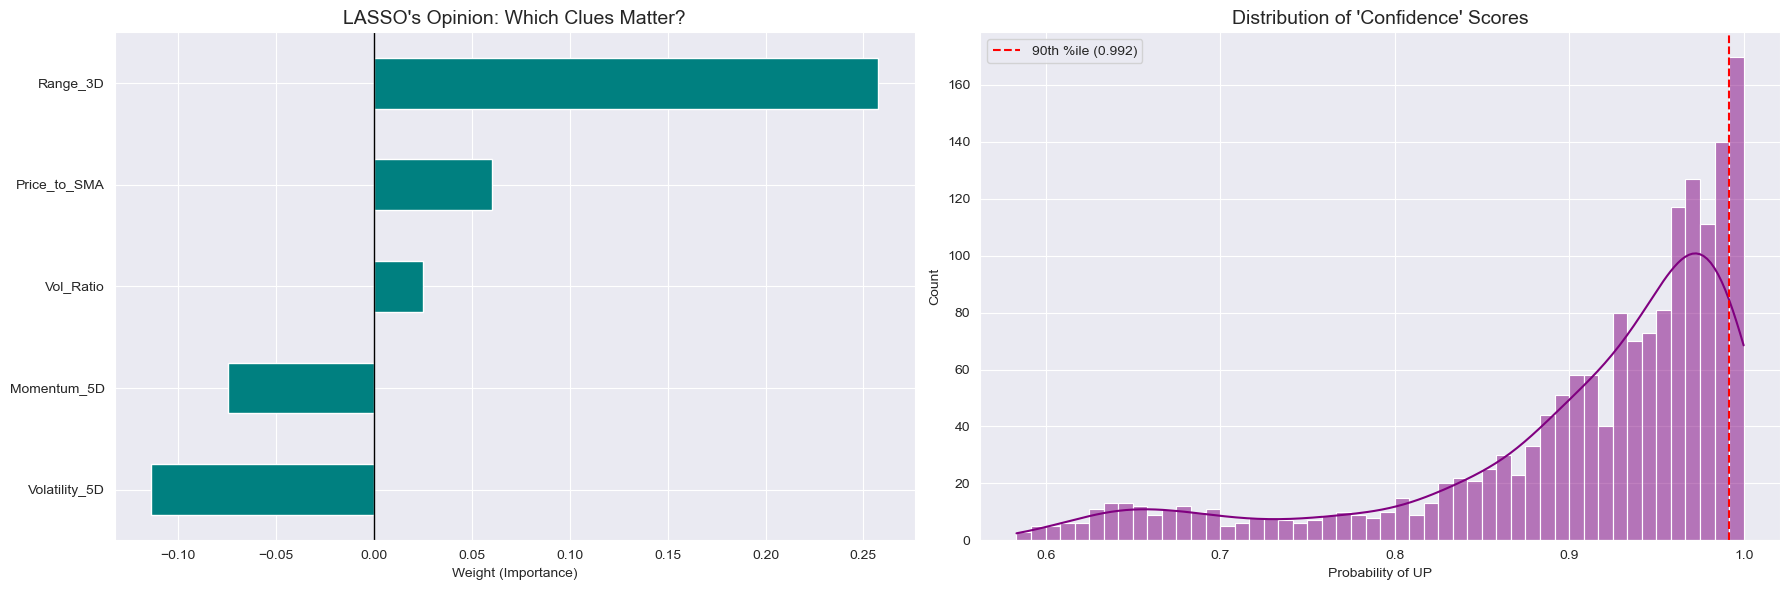

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# We look at the "Weights" the model assigned
lasso_coefs = pd.Series(model_hard.coef_[0], index=feature_cols).sort_values()
lasso_coefs.plot(kind='barh', ax=ax1, color='teal')
ax1.set_title("LASSO's Opinion: Which Clues Matter?", fontsize=14)
ax1.axvline(0, color='black', lw=1)
ax1.set_xlabel("Weight (Importance)")

sns.histplot(y_probs_hard, bins=50, kde=True, ax=ax2, color='purple')
ax2.axvline(threshold_90, color='red', linestyle='--', label=f'90th %ile ({threshold_90:.3f})')
ax2.set_title("Distribution of 'Confidence' Scores", fontsize=14)
ax2.set_xlabel("Probability of UP")
ax2.legend()

plt.tight_layout()
plt.show()

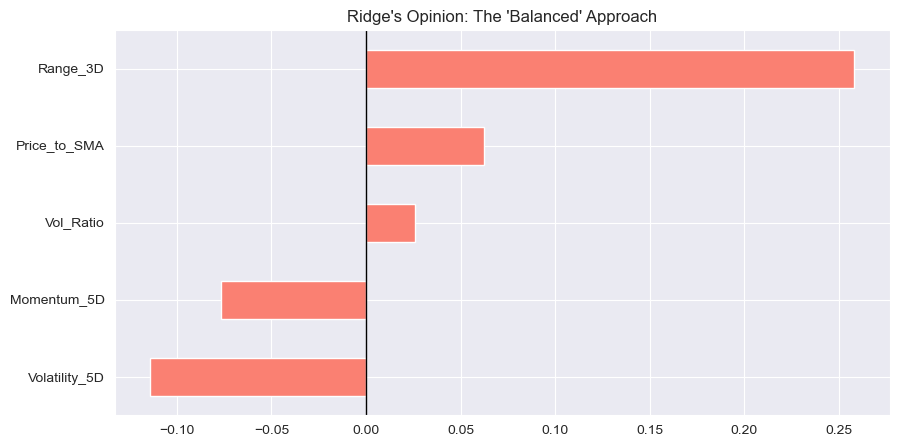

Ridge Confusion Matrix:
[[697  74]
 [789  91]]


In [ ]:
#Ridge

from sklearn.linear_model import LogisticRegression

model_ridge = LogisticRegression(
    penalty='l2',
    C=10,
    solver='lbfgs',
    class_weight='balanced',
    fit_intercept=True
)

model_ridge.fit(X_train_scaled, y_train)
y_probs_ridge = model_ridge.predict_proba(X_test_scaled)[:,1]
threshold_ridge = np.percentile(y_probs_ridge, 90)
y_pred_ridge = (y_probs_ridge > threshold_ridge).astype(int)

ridge_coefs = pd.Series(model_ridge.coef_[0], index=feature_cols).sort_values()

#Visualization
plt.figure(figsize=(10, 5))
ridge_coefs.plot(kind='barh', color='salmon')
plt.title("Ridge's Opinion: The 'Balanced' Approach")
plt.axvline(0, color='black', lw=1)
plt.show()

print("Ridge Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ridge))

Fold 6 | Train Win Rate: 50.44% | Test Win Rate: 46.67%
Fold 7 | Train Win Rate: 48.95% | Test Win Rate: 52.00%
Fold 8 | Train Win Rate: 47.17% | Test Win Rate: 50.67%
Fold 9 | Train Win Rate: 53.19% | Test Win Rate: 49.33%
Fold 10 | Train Win Rate: 52.40% | Test Win Rate: 56.00%


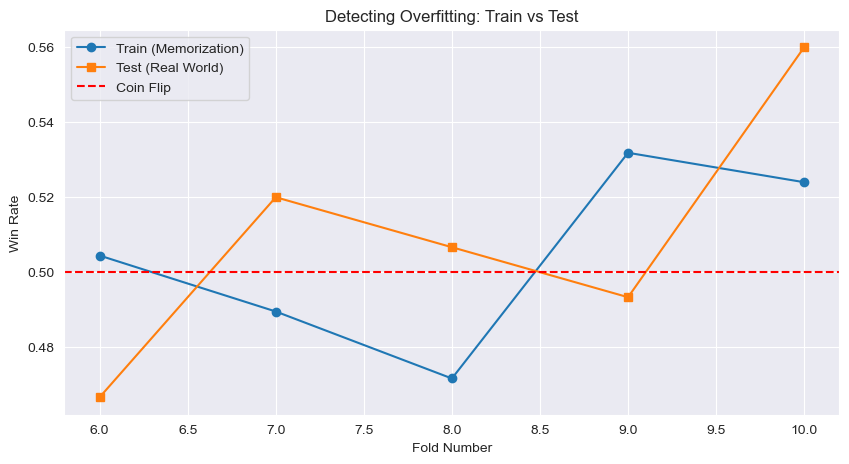

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, learning_curve, GridSearchCV  # <--- THIS was missing!
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize the Slicing Machine
tscv = TimeSeriesSplit(n_splits=10)

fold = 1
train_scores = []
test_scores = []

# Ensure we have our raw data ready
X_raw = df_model[feature_cols].values
y_all = df_model['Target'].values

for train_index, test_index in tscv.split(X_raw):
    # SKIP the first 5 folds (education phase)
    if fold <= 5:
        fold += 1
        continue

    # Split the data
    X_train_cv, X_test_cv = X_raw[train_index], X_raw[test_index]
    y_train_cv, y_test_cv = y_all[train_index], y_all[test_index]

    # Scale inside the loop (The Pro Way)
    cv_scaler = StandardScaler()
    X_train_cv = cv_scaler.fit_transform(X_train_cv)
    X_test_cv = cv_scaler.transform(X_test_cv)

    # Train the model
    model_cv = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', fit_intercept=False)
    model_cv.fit(X_train_cv, y_train_cv)

    # --- TESTING SCORE (The Future) ---
    test_probs = model_cv.predict_proba(X_test_cv)[:, 1]
    test_thresh = np.percentile(test_probs, 90)
    test_preds = (test_probs > test_thresh).astype(int)
    test_score = precision_score(y_test_cv, test_preds)

    # --- TRAINING SCORE (The Past/Open Book) ---
    train_probs = model_cv.predict_proba(X_train_cv)[:, 1]
    train_thresh = np.percentile(train_probs, 90)
    train_preds = (train_probs > train_thresh).astype(int)
    train_score = precision_score(y_train_cv, train_preds)

    train_scores.append(train_score)
    test_scores.append(test_score)

    print(f"Fold {fold} | Train Win Rate: {train_score:.2%} | Test Win Rate: {test_score:.2%}")
    fold += 1

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(range(6, 11), train_scores, label='Train (Memorization)', marker='o')
plt.plot(range(6, 11), test_scores, label='Test (Real World)', marker='s')
plt.axhline(0.50, color='red', linestyle='--', label='Coin Flip')
plt.title("Detecting Overfitting: Train vs Test")
plt.xlabel("Fold Number")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

In [ ]:
#Non Linear Intelligence (KNN)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score

knn = KNeighborsClassifier(n_neighbors=15, weights='distance')

knn.fit(X_train_scaled, y_train)

y_probs_knn = knn.predict_proba(X_test_scaled)[:, 1]

threshold_knn = np.percentile(y_probs_knn, 90)
y_pred_knn = (y_probs_knn > threshold_knn).astype(int)

win_rate_knn = precision_score(y_test, y_pred_knn)
print(f"KNN Strategy Win Rate: {win_rate_knn:.2%}")

print("\nKNN Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred_knn))

KNN Strategy Win Rate: 55.76%

KNN Confusion Matrix: 
[[698  73]
 [788  92]]


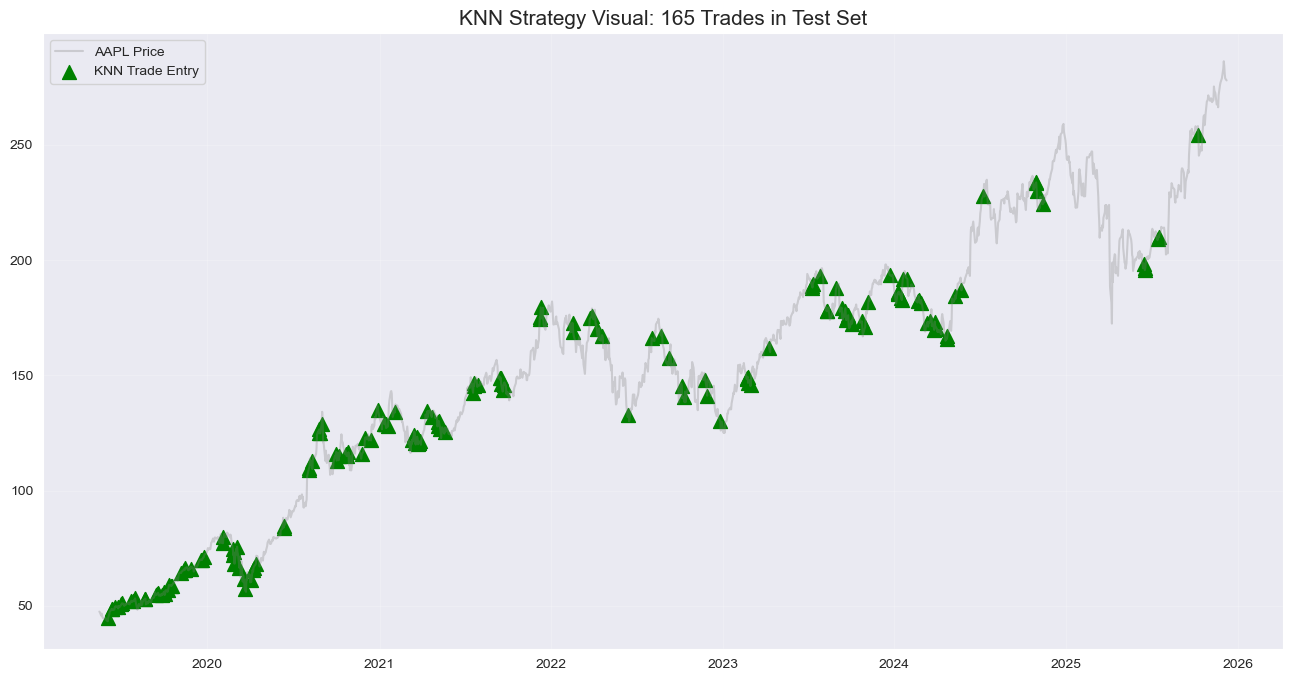

In [ ]:
import matplotlib.pyplot as plt

# 1. Create a plot of the Price (the Test set period)
plt.figure(figsize=(16, 8))
plt.plot(test_df.index, test_df['Price'], label='AAPL Price', color='gray', alpha=0.3)

# 2. Identify the Buy dates (where our KNN prediction was 1)
# We use the index of the test_df so they align perfectly
buy_signals = test_df.index[y_pred_knn == 1]
buy_prices = test_df['Price'][y_pred_knn == 1]

# 3. Plot Green dots at the entry points
plt.scatter(buy_signals, buy_prices, color='green', marker='^', s=100, label='KNN Trade Entry')

plt.title(f"KNN Strategy Visual: {len(buy_signals)} Trades in Test Set", fontsize=15)
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
# 1. Create an empty list for our signals
final_signals = []
days_since_last_trade = 0

# 2. Loop through the probabilities
# Note: y_probs_knn is your list of 'Confidence' scores
for prob in y_probs_knn:
    # If we haven't traded in 22 days (about 1 trading month)
    if days_since_last_trade > 22:
        threshold = np.percentile(y_probs_knn, 80) # Lower the bar!
    else:
        threshold = np.percentile(y_probs_knn, 95) # High standards

    if prob > threshold:
        final_signals.append(1)
        days_since_last_trade = 0 # Reset the clock
    else:
        final_signals.append(0)
        days_since_last_trade += 1

# 3. Check the new win rate and trade count
y_pred_forced = np.array(final_signals)
new_win_rate = precision_score(y_test, y_pred_forced)

print(f"Forced Strategy Trades: {sum(y_pred_forced)}")
print(f"Forced Strategy Win Rate: {new_win_rate:.2%}")

Forced Strategy Trades: 110
Forced Strategy Win Rate: 59.09%


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, confusion_matrix

# 1. Initialize the Decision Tree
# max_depth=3: We only allow the tree to ask 3 questions (prevents overfitting)
# min_samples_split=50: A branch must have at least 50 days in it to be valid
model_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=50, class_weight='balanced')

# 2. Fit the model
model_tree.fit(X_train_scaled, y_train)

# 3. Predict Probabilities
# Trees also give probabilities based on the "purity" of the leaf
y_probs_tree = model_tree.predict_proba(X_test_scaled)[:, 1]

# 4. Strategy: Top 10% (The Quant's Selective Filter)
threshold_tree = np.percentile(y_probs_tree, 90)
y_pred_tree = (y_probs_tree > threshold_tree).astype(int)

# 5. Check the Win Rate
win_rate_tree = precision_score(y_test, y_pred_tree)
print(f"Decision Tree Win Rate: {win_rate_tree:.2%}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

Decision Tree Win Rate: 0.00%

Confusion Matrix:
[[771   0]
 [880   0]]


/Users/samgeng14/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# 1. Increase depth slightly to get more unique probability values
model_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=20, class_weight='balanced')
model_tree.fit(X_train_scaled, y_train)

# 2. Get probabilities
y_probs_tree = model_tree.predict_proba(X_test_scaled)[:, 1]

# DEBUG: Let's see how many unique probability "buckets" we have now
print(f"Unique probability scores: {np.unique(y_probs_tree)}")

# 3. Apply a slightly more generous threshold (85th percentile)
threshold_tree = np.percentile(y_probs_tree, 85)

# 4. Use >= to catch the ties
y_pred_tree = (y_probs_tree >= threshold_tree).astype(int)

# 5. Re-check the stats
from sklearn.metrics import precision_score, confusion_matrix
print(f"\nDecision Tree Win Rate: {precision_score(y_test, y_pred_tree):.2%}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

Unique probability scores: [0.         0.28686118 0.31940076 0.43888181 0.51714288 0.58469697
 0.60805865 0.61855617 0.75593902 0.78251018]

Decision Tree Win Rate: 51.97%
Confusion Matrix:
[[331 440]
 [404 476]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix

# 1. Initialize the Forest
# n_estimators=100: Build 100 trees
# max_depth=5: Keep each tree simple to avoid overfitting
# n_jobs=-1: Use all your computer's CPU cores to speed it up
model_rf = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42, n_jobs=-1)

# 2. Fit the Forest
model_rf.fit(X_train_scaled, y_train)

# 3. Predict Probabilities
# Now we get a very smooth range of numbers!
y_probs_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

# 4. Strategy: Top 10% (The Professional Filter)
threshold_rf = np.percentile(y_probs_rf, 90)
y_pred_rf = (y_probs_rf >= threshold_rf).astype(int)

# 5. Check the Stats
win_rate_rf = precision_score(y_test, y_pred_rf)
print(f"Random Forest Win Rate: {win_rate_rf:.2%}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Win Rate: 48.80%

Confusion Matrix:
[[686  85]
 [799  81]]


In [ ]:
model_rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42
)

model_rf_tuned.fit(X_train_scaled, y_train)
y_probs_rf = model_rf_tuned.predict_proba(X_test_scaled)[:, 1]

threshold_rf = np.percentile(y_probs_rf, 95)
y_pred_rf = (y_probs_rf >= threshold_rf).astype(int)

from sklearn.metrics import precision_score
win_rate = precision_score(y_test, y_pred_rf)
print(f"Tuned RF Win Rate: {win_rate:.2%}")
print(confusion_matrix(y_test, y_pred_rf))

Tuned RF Win Rate: 46.99%
[[727  44]
 [841  39]]


In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_score

model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

model_xgb.fit(X_train_scaled, y_train)

y_probs_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]

threshold_xgb = np.percentile(y_probs_xgb, 55)
y_pred_xgb = (y_probs_xgb >= threshold_xgb).astype(int)

win_rate_xgb = precision_score(y_test, y_pred_xgb)
print(f"XGBoost Win Rate: {win_rate_xgb:.2%}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Win Rate: 52.14%

Confusion Matrix:
[[414 357]
 [491 389]]


In [ ]:
results = test_df.copy()
results['Signal'] = y_pred_xgb

results['Next_Day_Return'] = results['Log_Return'].shift(-1)
trading_cost = 0.001
results['Trades'] = results['Signal'].diff().fillna(0).abs()

results['Strategy_Return'] = (results['Signal'] * results['Next_Day_Return']) - (results['Trades'] * trading_cost)

results = results.dropna()

results['Market_Growth'] = np.exp(results['Log_Return'].cumsum())
results['Strategy_Growth'] = np.exp(results['Strategy_Return'].cumsum())

daily_std = results['Strategy_Return'].std()
if daily_std != 0:
    annual_sharpe = (results['Strategy_Return'].mean() / daily_std) * np.sqrt(252)
else:
    annual_sharpe = 0

peak = results['Strategy_Growth'].cummax()
drawdown = (results['Strategy_Growth'] - peak) / peak
max_drawdown = drawdown.min()

print(f"--- Honest XGBoost Strategy Report ---")
print(f"Final Return: {(results['Strategy_Growth'].iloc[-1] - 1):.2%}")
print(f"Annualized Sharpe Ratio: {annual_sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

--- Honest XGBoost Strategy Report ---
Final Return: 61.23%
Annualized Sharpe Ratio: 0.40
Max Drawdown: -25.44%


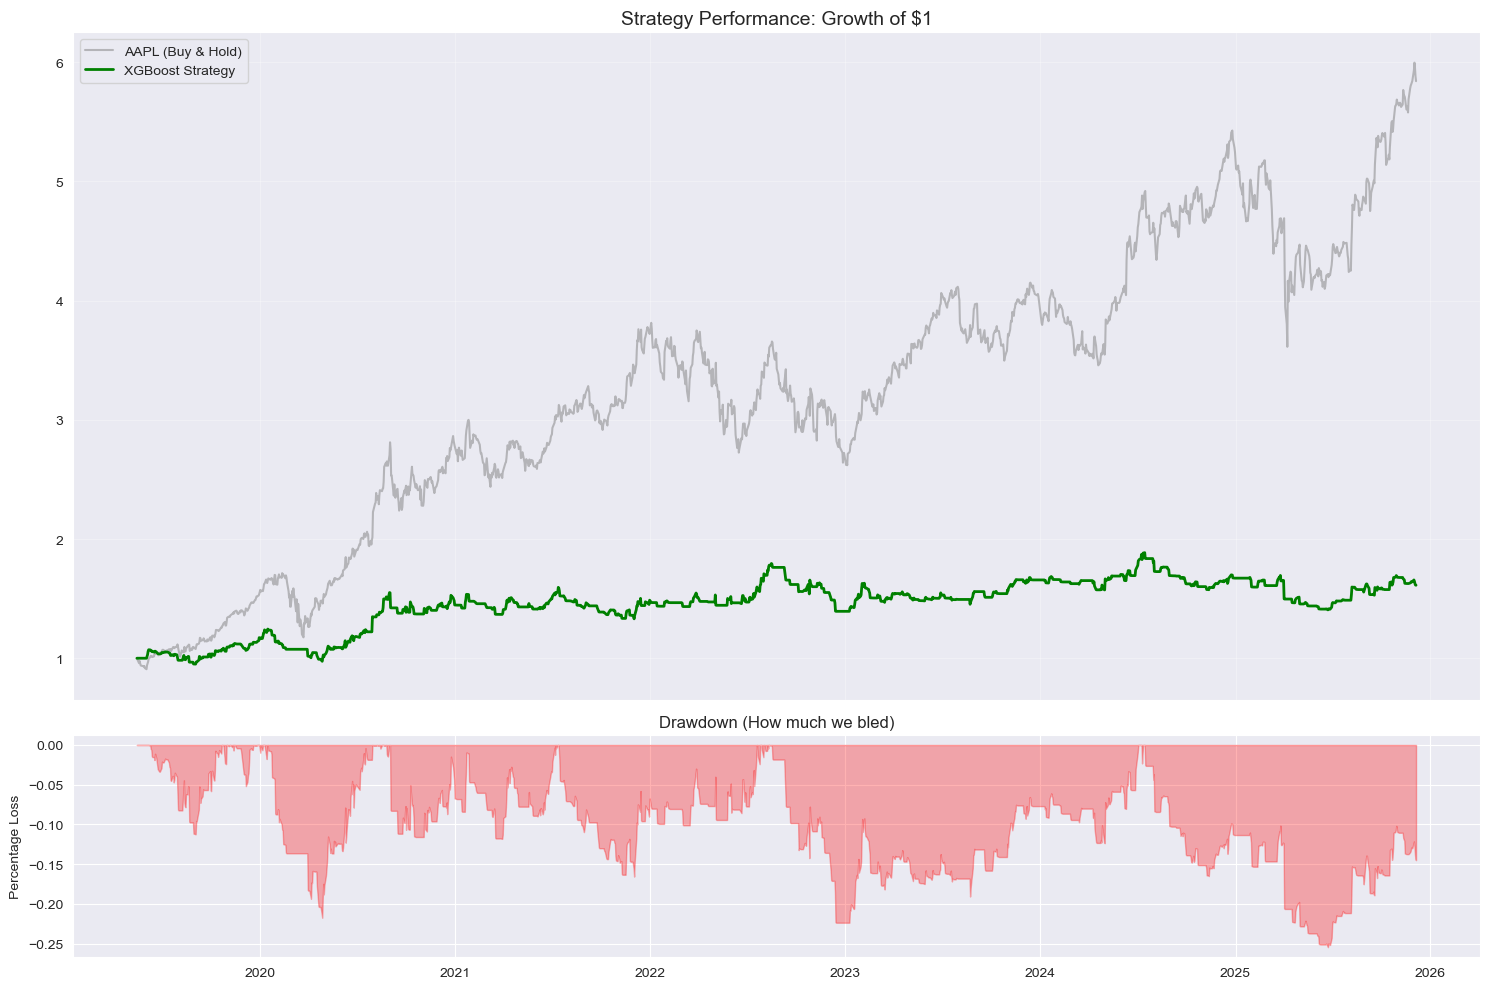

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Chart 1: Equity Curve
ax1.plot(results.index, results['Market_Growth'], label='AAPL (Buy & Hold)', color='gray', alpha=0.5)
ax1.plot(results.index, results['Strategy_Growth'], label='XGBoost Strategy', color='green', lw=2)
ax1.set_title("Strategy Performance: Growth of $1", fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# Chart 2: Drawdown (The "Under-Water" Chart)
ax2.fill_between(results.index, 0, drawdown, color='red', alpha=0.3)
ax2.set_title("Drawdown (How much we bled)", fontsize=12)
ax2.set_ylabel("Percentage Loss")

plt.tight_layout()
plt.show()

In [ ]:
# 1. Calculate Downside Deviation (for Sortino)
# We only look at returns that are negative (< 0)
downside_returns = results.loc[results['Strategy_Return'] < 0, 'Strategy_Return']
downside_std = downside_returns.std() * np.sqrt(252)

# 2. Sortino Ratio
# Annual Return / Annual Downside Deviation
annual_return = results['Strategy_Return'].mean() * 252
sortino_ratio = annual_return / downside_std

# 3. Value at Risk (VaR) - 95% Confidence
# "What is the worst 5% of days?"
var_95 = np.percentile(results['Strategy_Return'], 5)

# 4. Conditional VaR (CVaR / Expected Shortfall)
# "If we hit that worst 5%, what is the average loss?"
cvar_95 = results.loc[results['Strategy_Return'] <= var_95, 'Strategy_Return'].mean()

print(f"--- Risk Health Check ---")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"95% Daily VaR: {var_95:.2%}")
print(f"95% Daily CVaR: {cvar_95:.2%}")

--- Risk Health Check ---
Annualized Return: 7.29%
Sortino Ratio: 0.42
95% Daily VaR: -1.75%
95% Daily CVaR: -2.90%


In [ ]:
# 1. RSI (Relative Strength Index - 14 day)
# Measures the speed and change of price movements.
delta = df['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 2. MACD (Moving Average Convergence Divergence)
# EMA = Exponential Moving Average (gives more weight to recent days)
ema_12 = df['Price'].ewm(span=12, adjust=False).mean()
ema_26 = df['Price'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

# 3. Bollinger Band Position
# Where is the price relative to its 20-day "Normal" range?
std_20 = df['Price'].rolling(window=20).std()
sma_20 = df['Price'].rolling(window=20).mean()
df['BB_Upper'] = sma_20 + (std_20 * 2)
df['BB_Lower'] = sma_20 - (std_20 * 2)
# %B tells us where we are between the bands (1.0 = top, 0.0 = bottom)
df['BB_Pos'] = (df['Price'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

# Clean up the new NaNs
df_expanded = df.dropna()

# Update our feature list
extended_features = feature_cols + ['RSI', 'MACD', 'BB_Pos']
print(f"New Feature List: {extended_features}")

New Feature List: ['Momentum_5D', 'Volatility_5D', 'Price_to_SMA', 'Vol_Ratio', 'Range_3D', 'RSI', 'MACD', 'BB_Pos']


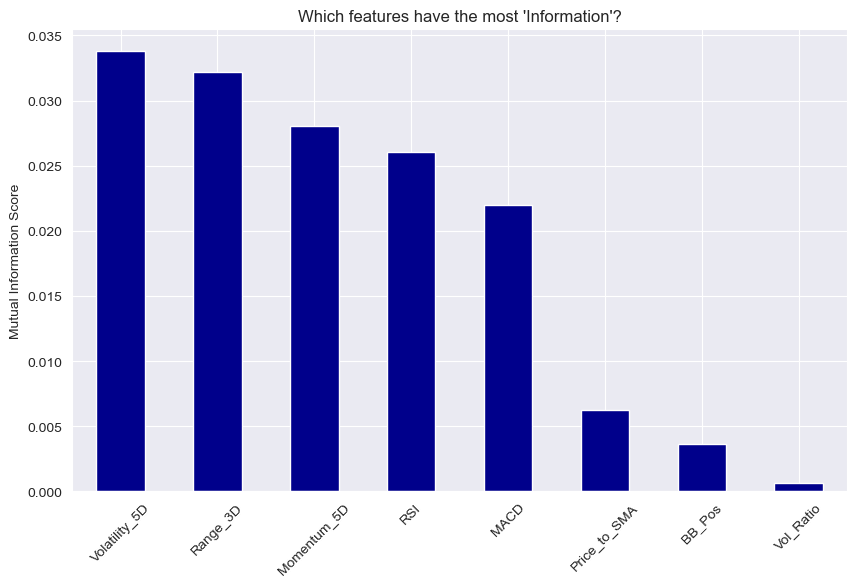

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# 1. Prepare data (X = Clues, y = Target)
X_rank = df_expanded[extended_features]
y_rank = (df_expanded['Log_Return'].shift(-1) > 0).astype(int)

# Drop the last row because we don't know "tomorrow" for the final date
X_rank = X_rank[:-1]
y_rank = y_rank[:-1]

# 2. Calculate Information Gain
# We use mutual_info_classif because our target is 0 or 1
# discrete_features=False because our indicators (RSI, etc.) are continuous floats
mi_scores = mutual_info_classif(X_rank, y_rank, discrete_features=False, random_state=42)

# 3. Visualize the Results
mi_results = pd.Series(mi_scores, index=extended_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_results.plot(kind='bar', color='darkblue')
plt.title("Which features have the most 'Information'?")
plt.ylabel("Mutual Information Score")
plt.xticks(rotation=45)
plt.show()

In [ ]:
 # 1. Define the "Elite" Feature list (Top 5 from your chart)
elite_features = ['Volatility_5D', 'Range_3D', 'Momentum_5D', 'RSI', 'MACD']

# 2. Re-prepare the data with these specific clues
X_elite = df_expanded[elite_features]
y_elite = (df_expanded['Log_Return'].shift(-1) > 0).astype(int)

# Drop the last row
X_elite = X_elite[:-1]
y_elite = y_elite[:-1]

# 3. Perform a fresh Time-Series Split
split = int(len(X_elite) * 0.8)
X_train_el, X_test_el = X_elite.iloc[:split], X_elite.iloc[split:]
y_train_el, y_test_el = y_elite.iloc[:split], y_elite.iloc[split:]

# 4. Scale the elite features
scaler_el = StandardScaler()
X_train_el_sc = scaler_el.fit_transform(X_train_el)
X_test_el_sc = scaler_el.transform(X_test_el)

# 5. Retrain the XGBoost Engine
import xgboost as xgb
model_elite = xgb.XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
model_elite.fit(X_train_el_sc, y_train_el)

# 6. Evaluate the "Cleaned" Win Rate
y_probs_el = model_elite.predict_proba(X_test_el_sc)[:, 1]
threshold_el = np.percentile(y_probs_el, 90)
y_pred_el = (y_probs_el >= threshold_el).astype(int)

from sklearn.metrics import precision_score
print(f"Elite Model Win Rate: {precision_score(y_test_el, y_pred_el):.2%}")
print(confusion_matrix(y_test_el, y_pred_el))

Elite Model Win Rate: 53.98%
[[591 179]
 [670 210]]


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
import numpy as np

# 1. Setup the Purged Splitter
# We will use 5 splits (Folds)
tscv = TimeSeriesSplit(n_splits=5)
PURGE_DAYS = 10 # We will delete 10 days between Train and Test

fold = 1
purged_scores = []

# Using our Elite Features
X_elite_raw = df_expanded[elite_features].values
y_elite_all = (df_expanded['Log_Return'].shift(-1) > 0).astype(int)[:-1].values
X_elite_raw = X_elite_raw[:-1] # Match the lengths

for train_idx, test_idx in tscv.split(X_elite_raw):
    # --- THE PURGE ---
    # We remove the last 10 days from the training index
    purged_train_idx = train_idx[:-PURGE_DAYS]

    # Split the data
    X_train_p, X_test_p = X_elite_raw[purged_train_idx], X_elite_raw[test_idx]
    y_train_p, y_test_p = y_elite_all[purged_train_idx], y_elite_all[test_idx]

    # Scale inside the loop (Professional standard)
    p_scaler = StandardScaler()
    X_train_p_sc = p_scaler.fit_transform(X_train_p)
    X_test_p_sc = p_scaler.transform(X_test_p)

    # Train Elite XGBoost
    model_p = xgb.XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
    model_p.fit(X_train_p_sc, y_train_p)

    # Probability Strategy (90th percentile)
    probs_p = model_p.predict_proba(X_test_p_sc)[:, 1]
    thresh_p = np.percentile(probs_p, 90)
    preds_p = (probs_p >= thresh_p).astype(int)

    # Score it
    fold_score = precision_score(y_test_p, preds_p)
    purged_scores.append(fold_score)

    print(f"Fold {fold} (Purged) Win Rate: {fold_score:.2%}")
    fold += 1

print(f"\nAverage Purged Win Rate: {np.mean(purged_scores):.2%}")

Fold 1 (Purged) Win Rate: 45.14%
Fold 2 (Purged) Win Rate: 44.51%
Fold 3 (Purged) Win Rate: 52.47%
Fold 4 (Purged) Win Rate: 59.71%
Fold 5 (Purged) Win Rate: 50.41%

Average Purged Win Rate: 50.45%


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, precision_score
import pandas as pd
import numpy as np

# 1. Define the "Engine" (Base Model)
# We keep scale_pos_weight to help with the "Up-bias"
base_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=1.2)

# 2. Define the "Tuning Options" (The Grid)
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [2, 3, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}

# 3. Setup the Time-Series Splitter (The Wall of Time)
tscv = TimeSeriesSplit(n_splits=5)

# 4. Setup the Custom Scorer (The "No Warning" Win Rate)
custom_precision = make_scorer(precision_score, zero_division=0)

# 5. Initialize the Search Engine
grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring=custom_precision,
    n_jobs=-1,
    verbose=1
)

# 6. Run the math on your Elite Scaled Training Data
grid_search.fit(X_train_el_sc, y_train_el)

print(f"\nOptimization Complete.")
print(f"Best Settings Found: {grid_search.best_params_}")
print(f"Best Training Win Rate: {grid_search.best_score_:.2%}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Optimization Complete.
Best Settings Found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Training Win Rate: 50.49%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class QuantNet(nn.Module):
    def __init__(self, input_size):
        super(QuantNet, self, ).__init__()

        self.hidden1 = nn.Linear(input_size, 16)
        self.relu1 = nn.ReLU()

        self.hidden2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()

        self.output = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # This defines the "Flow" of data through the brain
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x
model_ann = QuantNet(input_size=5)
print(model_ann)


QuantNet(
  (hidden1): Linear(in_features=5, out_features=16, bias=True)
  (relu1): ReLU()
  (hidden2): Linear(in_features=16, out_features=8, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Training the Neural Network...
Epoch [10/100], Loss: 0.7027
Epoch [20/100], Loss: 0.6982
Epoch [30/100], Loss: 0.6941
Epoch [40/100], Loss: 0.6898
Epoch [50/100], Loss: 0.6854
Epoch [60/100], Loss: 0.6810
Epoch [70/100], Loss: 0.6768
Epoch [80/100], Loss: 0.6733
Epoch [90/100], Loss: 0.6703
Epoch [100/100], Loss: 0.6680


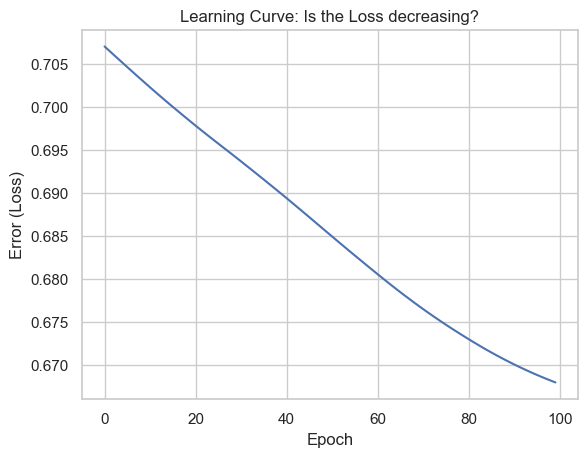

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Convert our "Elite" Data to PyTorch Tensors
# We use .values to get the numbers, and float32 is the required precision for NN
X_train_tensor = torch.tensor(X_train_el_sc.astype(np.float32))
y_train_tensor = torch.tensor(y_train_el.values.astype(np.float32)).view(-1, 1)

X_test_tensor = torch.tensor(X_test_el_sc.astype(np.float32))
y_test_tensor = torch.tensor(y_test_el.values.astype(np.float32)).view(-1, 1)

# 2. Define the Loss Function and Optimizer
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.Adam(model_ann.parameters(), lr=0.001) # Learning rate of 0.001

# 3. The Training Loop
epochs = 100 # How many times the brain reads the whole history
losses = []

print("Training the Neural Network...")
for epoch in range(epochs):
    # A. Forward Pass: Make a prediction
    outputs = model_ann(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # B. Backward Pass: Assign the blame (Backpropagation)
    optimizer.zero_grad() # Clear previous gradients
    loss.backward()       # Calculate new gradients

    # C. Update: Turn the 241 dials
    optimizer.step()

    losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Plot the learning curve
plt.plot(losses)
plt.title("Learning Curve: Is the Loss decreasing?")
plt.xlabel("Epoch")
plt.ylabel("Error (Loss)")
plt.show()

--- ANN Strategy Final Report ---
Neural Network Win Rate: 56.45%

Confusion Matrix:
[[662 108]
 [740 140]]


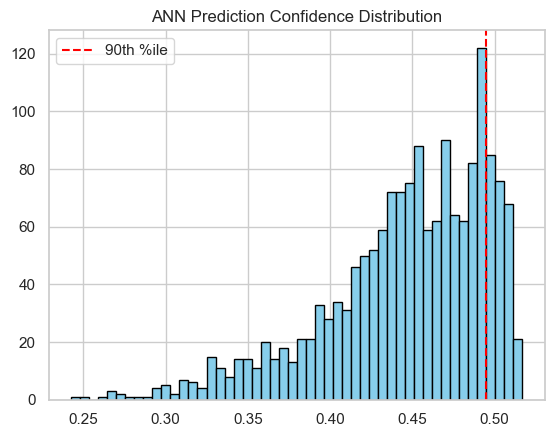

In [ ]:
model_ann.eval()

with torch.no_grad():
    ann_probs_raw = model_ann(X_test_tensor)
    ann_probs = ann_probs_raw.numpy().flatten()

ann_threshold = np.percentile(ann_probs, 85)
ann_preds = (ann_probs >= ann_threshold).astype(int)

ann_win_rate = precision_score(y_test_el, ann_preds)

print(f"--- ANN Strategy Final Report ---")
print(f"Neural Network Win Rate: {ann_win_rate:.2%}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_el, ann_preds))

# 5. Probability Distribution Check
plt.hist(ann_probs, bins=50, color='skyblue', edgecolor='black')
plt.axvline(ann_threshold, color='red', linestyle='--', label='90th %ile')
plt.title("ANN Prediction Confidence Distribution")
plt.legend()
plt.show()


In [58]:
import numpy as np

def monte_carlo(S0, K, T, r, sigma, num_sim=10000):
    payoffs = []
    for _ in range(num_sim):
        Z = np.random.randn()
        ST = S0 * np.exp((r-0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

        payoffs.append(max(ST - K, 0))
    price = np.exp(-r * T) * np.mean(payoffs)
    return price